In [165]:
# from google.colab import drive
# drive.mount('/content/drive')

In [166]:
# !mkdir -p ~/.kaggle
# !cp /kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [167]:
# datasets = {
#     "plant_village": "emmarex/plantdisease",
#     "plant_doc": "abdulhasibuddin/plant-doc-dataset",
#     "cassava": "nirmalsankalana/cassava-leaf-disease-classification"
# }

# for name, dataset in datasets.items():
#     print(f"📦 Downloading {name} dataset...")
#     os.system(f"kaggle datasets download -d {dataset} -p ./datasets/{name}")

In [168]:
# for name in datasets.keys():
#     dataset_dir = f"./datasets/{name}"
#     for file in os.listdir(dataset_dir):
#         if file.endswith(".zip"):
#             zip_path = os.path.join(dataset_dir, file)
#             print(f"📂 Extracting {zip_path}...")
#             with zipfile.ZipFile(zip_path, "r") as zip_ref:
#                 zip_ref.extractall(dataset_dir)
#             os.remove(zip_path)

In [208]:
import os
import pickle
import random
import numpy as np
import pandas as pd
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall


In [170]:
def setup_environment(seed=42, use_cuda=True):
    """Set up environment, seeds, and device."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = 'cuda' if (torch.cuda.is_available() and use_cuda) else 'cpu'
    print("✅ Torch device:", device)

    return device

device = setup_environment()

✅ Torch device: cuda


In [171]:
CFG = {
    "image_size": 224,
    "batch_size": 32,
    "num_workers": 0,
    "epochs_stage1": 20,  # PlantVillage
    "epochs_stage2": 20,  # Cassava
    "lr_stage1": 3e-4,
    "lr_stage2": 1e-4,
    "weight_decay": 1e-4,
    "early_stop_patience": 4
}

In [172]:
DATA_BASE_PATH = "./datasets"
PLANTVILLAGE_PATH = os.path.join(DATA_BASE_PATH, "plant_village")
CASSAVA_PATH = os.path.join(DATA_BASE_PATH, "cassava")

os.makedirs("./datasets/checkpoints", exist_ok=True)
print("✅ Paths and configs set up successfully.")

✅ Paths and configs set up successfully.


In [173]:
def build_plantvillage_dataframe(root_dir, mode="flat"):
    """Build a DataFrame listing all images with crop/disease info."""
    records = []
    if mode == "flat":  # PlantVillage style
        for crop in os.listdir(root_dir):
            crop_path = os.path.join(root_dir, crop)
            if not os.path.isdir(crop_path): continue
            for disease in os.listdir(crop_path):
                dpath = os.path.join(crop_path, disease)
                for f in glob(os.path.join(dpath, "*.jpg")) + glob(os.path.join(dpath, "*.png")):
                    records.append([crop, disease, f])
    return pd.DataFrame(records, columns=["Crop","Disease","Path"])

def create_label_mapping(df, label_column="Disease"):
    """Map disease labels to numeric ids."""
    diseases = sorted(df[label_column].unique())
    label2id = {d:i for i,d in enumerate(diseases)}
    df["label_id"] = df[label_column].map(label2id)
    num_classes = len(label2id)
    return df, label2id, num_classes

In [174]:
def build_cassava_dataframe(base_path="./datasets/cassava"):
    """Build Cassava dataset dataframe."""
    IMAGE_PATH = os.path.join(base_path, "images")
    disease_classes = sorted(os.listdir(IMAGE_PATH))
    print(f"Classes found: {disease_classes}")

    image_paths = []
    labels = []

    for idx, disease in enumerate(disease_classes):
        class_folder = os.path.join(IMAGE_PATH, disease)
        images = glob(os.path.join(class_folder, "*.jpg"))
        image_paths.extend(images)
        labels.extend([idx] * len(images))  # Assign disease class label

    df = pd.DataFrame({"image_path": image_paths, "label": labels})
    print(f"Dataset created with {len(df)} images.")
    return df, disease_classes

In [175]:
def make_transforms(img_size=224, aug=True):
    """Create transformations for data augmentation or basic resizing."""
    if aug:
        return A.Compose([
            A.RandomResizedCrop((img_size, img_size), scale=(0.75, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(p=0.4),
            A.MotionBlur(p=0.2),
            A.RandomShadow(p=0.2),
            A.RandomFog(p=0.1),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

In [176]:
class PlantDataset(Dataset):
    """Generic plant dataset for loading and transforming images."""
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["Path"]).convert("RGB")
        img = np.array(img)
        img = self.tfms(image=img)["image"]
        label = row["label_id"]
        return img, label

In [177]:
class CassavaDataset(Dataset):
    """Cassava dataset for loading and transforming images."""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        image = Image.open(img_path).convert("RGB")
        label = self.df.iloc[idx]["label"]

        if self.transform:
            image = self.transform(image=np.array(image))["image"]

        return image, label

In [178]:
class EarlyStopping:
    """Stop training when val loss doesn't improve after patience epochs."""
    def __init__(self, patience=4, verbose=True, save_path=None):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.verbose = verbose
        self.save_path = save_path

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"✅ Validation loss improved → {val_loss:.4f}")
            if self.save_path:
                torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            print(f"⚠️ No improvement for {self.counter}/{self.patience} epochs.")
        return self.counter >= self.patience

In [179]:
def evaluate_plantvillage_model(model, loader, criterion, num_classes):
    model.eval()
    acc_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    f1_metric  = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
    prec_metric = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    rec_metric = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

    val_loss, acc, f1, prec, rec = 0.0, 0.0, 0.0, 0.0, 0.0
    true_labels = []
    predicted_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validate", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * len(imgs)

            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(1)

            acc += acc_metric(preds, labels) * len(imgs)
            f1  += f1_metric(preds, labels) * len(imgs)
            prec += prec_metric(preds, labels) * len(imgs)
            rec += rec_metric(preds, labels) * len(imgs)


            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    n = len(loader.dataset)
    return val_loss/n, acc/n, f1/n, prec/n, rec/n, true_labels, predicted_labels, np.array(all_probs)

In [180]:
def setup_model(num_classes, lr=3e-4, weight_decay=1e-4):
    """Initialize the model, loss function, optimizer, and scheduler."""
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    return model, criterion, optimizer, scheduler

In [200]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stop, epochs=20, dataset_name="plantvillage", class_names=None, num_classes=None):
    """Train the model over a specified number of epochs and plot metrics."""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_f1s = []
    val_f1s = []
    train_precs = []
    val_precs = []
    train_recs = []
    val_recs = []


    for epoch in range(epochs):
        print(f"\n🌿 Epoch {epoch+1}/{epochs}")

        model.train()
        running_loss = 0.0
        acc_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
        f1_metric  = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
        prec_metric = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
        rec_metric = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

        for imgs, labels in tqdm(train_loader, desc="Train", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(imgs)

            train_preds = logits.argmax(1)
            acc_metric(train_preds, labels)
            f1_metric(train_preds, labels)
            prec_metric(train_preds, labels)
            rec_metric(train_preds, labels)


        tr_loss = running_loss / len(train_loader.dataset)
        tr_acc = acc_metric.compute()
        tr_f1 = f1_metric.compute()
        tr_prec = prec_metric.compute()
        tr_rec = rec_metric.compute()

        if dataset_name == "plantvillage":
            val_loss, val_acc, val_f1, val_prec, val_rec, true_labels, predicted_labels, all_probs = evaluate_plantvillage_model(model, val_loader, criterion, num_classes)
            print(f"Train Loss:{tr_loss:.4f} | Train Acc:{tr_acc:.3f} | Train F1:{tr_f1:.3f} | Train Prec:{tr_prec:.3f} | Train Rec:{tr_rec:.3f} | Val Loss:{val_loss:.4f} | Val Acc:{val_acc:.3f} | Val F1:{val_f1:.3f} | Val Prec:{val_prec:.3f} | Val Rec:{val_rec:.3f}")
        elif dataset_name == "cassava":
             val_loss, val_acc, val_f1, val_prec, val_rec, true_labels, predicted_labels, all_probs = evaluate_cassava_model(model, val_loader, criterion, num_classes)
             print(f"Train Loss:{tr_loss:.4f} | Train Acc:{tr_acc:.3f} | Train F1:{tr_f1:.3f} | Train Prec:{tr_prec:.3f} | Train Rec:{tr_rec:.3f} | Val Loss:{val_loss:.4f} | Val Acc:{val_acc:.3f} | Val F1:{val_f1:.3f} | Val Prec:{val_prec:.3f} | Val Rec:{val_rec:.3f}")


        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc.item())
        val_accs.append(val_acc.item())
        train_f1s.append(tr_f1.item())
        val_f1s.append(val_f1.item())
        train_precs.append(tr_prec.item())
        val_precs.append(val_prec.item())
        train_recs.append(tr_rec.item())
        val_recs.append(val_rec.item())


        scheduler.step(val_loss)

        if early_stop.step(val_loss, model):
            print("⏹️ Early stopping triggered!")
            break

    if early_stop.save_path:
        model.load_state_dict(torch.load(early_stop.save_path))

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    print("\nEvaluating best model on validation set...")
    if dataset_name == "plantvillage":
        val_loss, val_acc, val_f1, val_prec, val_rec, true_labels, predicted_labels, all_probs = evaluate_plantvillage_model(model, val_loader, criterion, num_classes)
        plot_confusion_matrix(true_labels, predicted_labels, class_names)
        plot_roc_curves(true_labels, all_probs, class_names)

    elif dataset_name == "cassava":
        val_loss, val_acc, val_f1, val_prec, val_rec, true_labels, predicted_labels, all_probs = evaluate_cassava_model(model, val_loader, criterion, num_classes)
        plot_confusion_matrix(true_labels, predicted_labels, class_names)
        plot_roc_curves(true_labels, all_probs, class_names)

In [182]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    """Plots training and validation loss and accuracy curves."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curves(y_true, y_probs, class_names):
    """Plots ROC curves for each class."""
    n_classes = len(class_names)
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for class {class_names[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [183]:
def get_severity(confidence):
    """Classify severity based on confidence score."""
    if confidence > 0.85:
        return "High"
    elif confidence > 0.7:
        return "Medium"
    else:
        return "Low"

In [184]:
def evaluate_cassava_model(model, loader, criterion, num_classes):
    """Evaluate the Cassava model on the validation set."""
    model.eval()  # Set model to evaluation mode

    val_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
    prec_metric = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    rec_metric = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

    true_labels = []
    predicted_labels = []
    all_probs = []


    with torch.no_grad():  # Disable gradient calculation
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item() * len(imgs)  # Accumulate loss

            # Compute accuracy and F1 score
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(1)

            acc_metric(preds, labels)
            f1_metric(preds, labels)
            prec_metric(preds, labels)
            rec_metric(preds, labels)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    # Calculate final values
    val_loss /= len(loader.dataset)
    val_acc = acc_metric.compute()
    val_f1 = f1_metric.compute()
    val_prec = prec_metric.compute()
    val_rec = rec_metric.compute()

    return val_loss, val_acc, val_f1, val_prec, val_rec, true_labels, predicted_labels, np.array(all_probs)

In [185]:
# PlantVillage Model
plantvillage_df = build_plantvillage_dataframe(PLANTVILLAGE_PATH)
train_plantvillage_df, val_plantvillage_df = train_test_split(plantvillage_df, test_size=0.1, stratify=plantvillage_df["Disease"], random_state=42)
train_plantvillage_df, plantvillage_label2id, plantvillage_num_classes = create_label_mapping(train_plantvillage_df)
val_plantvillage_df["label_id"] = val_plantvillage_df["Disease"].map(plantvillage_label2id)
train_plantvillage_ds = PlantDataset(train_plantvillage_df, make_transforms(CFG["image_size"], aug=True))
val_plantvillage_ds = PlantDataset(val_plantvillage_df, make_transforms(CFG["image_size"], aug=False))

train_plantvillage_loader = DataLoader(train_plantvillage_ds, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"])
val_plantvillage_loader = DataLoader(val_plantvillage_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"])

In [186]:
model_stage1, criterion, optimizer, scheduler = setup_model(plantvillage_num_classes)

In [187]:
early_stop = EarlyStopping(patience=CFG["early_stop_patience"], save_path="./datasets/checkpoints/efficientnetB0_detection_plant_village.pth")


🌿 Epoch 1/20


Train Loss:0.3591 | Train Acc:0.874 | Train F1:0.875 | Train Prec:0.877 | Train Rec:0.874 | Val Loss:0.0410 | Val Acc:0.982 | Val F1:0.981 | Val Prec:0.984 | Val Rec:0.982
✅ Validation loss improved → 0.0410

🌿 Epoch 2/20


Train Loss:0.1109 | Train Acc:0.959 | Train F1:0.959 | Train Prec:0.959 | Train Rec:0.959 | Val Loss:0.0446 | Val Acc:0.983 | Val F1:0.981 | Val Prec:0.983 | Val Rec:0.983
⚠️ No improvement for 1/4 epochs.

🌿 Epoch 3/20


Train Loss:0.0789 | Train Acc:0.970 | Train F1:0.970 | Train Prec:0.970 | Train Rec:0.970 | Val Loss:0.0286 | Val Acc:0.987 | Val F1:0.986 | Val Prec:0.988 | Val Rec:0.987
✅ Validation loss improved → 0.0286

🌿 Epoch 4/20


Train Loss:0.0607 | Train Acc:0.976 | Train F1:0.977 | Train Prec:0.977 | Train Rec:0.976 | Val Loss:0.0369 | Val Acc:0.988 | Val F1:0.987 | Val Prec:0.990 | Val Rec:0.988
⚠️ No improvement for 1/4 epochs.

🌿 Epoch 5/20


Train Loss:0.0587 | Train Acc:0.979 | Train F1:0.979 | Train Prec:0.979 | Train Rec:0.979 | Val Loss:0.0555 | Val Acc:0.971 | Val F1:0.971 | Val Prec:0.975 | Val Rec:0.971
⚠️ No improvement for 2/4 epochs.

🌿 Epoch 6/20


Train Loss:0.0533 | Train Acc:0.981 | Train F1:0.981 | Train Prec:0.980 | Train Rec:0.981 | Val Loss:0.0200 | Val Acc:0.995 | Val F1:0.995 | Val Prec:0.996 | Val Rec:0.995
✅ Validation loss improved → 0.0200

🌿 Epoch 7/20


Train Loss:0.0431 | Train Acc:0.983 | Train F1:0.984 | Train Prec:0.984 | Train Rec:0.983 | Val Loss:0.0243 | Val Acc:0.991 | Val F1:0.991 | Val Prec:0.992 | Val Rec:0.991
⚠️ No improvement for 1/4 epochs.

🌿 Epoch 8/20


Train Loss:0.0447 | Train Acc:0.984 | Train F1:0.984 | Train Prec:0.985 | Train Rec:0.984 | Val Loss:0.0440 | Val Acc:0.988 | Val F1:0.988 | Val Prec:0.990 | Val Rec:0.988
⚠️ No improvement for 2/4 epochs.

🌿 Epoch 9/20


Train Loss:0.0400 | Train Acc:0.987 | Train F1:0.987 | Train Prec:0.987 | Train Rec:0.987 | Val Loss:0.0325 | Val Acc:0.991 | Val F1:0.992 | Val Prec:0.993 | Val Rec:0.991
⚠️ No improvement for 3/4 epochs.

🌿 Epoch 10/20


Train Loss:0.0421 | Train Acc:0.984 | Train F1:0.984 | Train Prec:0.984 | Train Rec:0.984 | Val Loss:0.0179 | Val Acc:0.993 | Val F1:0.993 | Val Prec:0.994 | Val Rec:0.993
✅ Validation loss improved → 0.0179

🌿 Epoch 11/20


Train Loss:0.0329 | Train Acc:0.988 | Train F1:0.988 | Train Prec:0.988 | Train Rec:0.988 | Val Loss:0.0238 | Val Acc:0.991 | Val F1:0.991 | Val Prec:0.993 | Val Rec:0.991
⚠️ No improvement for 1/4 epochs.

🌿 Epoch 12/20


Train Loss:0.0352 | Train Acc:0.987 | Train F1:0.988 | Train Prec:0.989 | Train Rec:0.987 | Val Loss:0.0364 | Val Acc:0.991 | Val F1:0.990 | Val Prec:0.993 | Val Rec:0.991
⚠️ No improvement for 2/4 epochs.

🌿 Epoch 13/20


Train Loss:0.0359 | Train Acc:0.988 | Train F1:0.988 | Train Prec:0.989 | Train Rec:0.988 | Val Loss:0.0340 | Val Acc:0.993 | Val F1:0.993 | Val Prec:0.994 | Val Rec:0.993
⚠️ No improvement for 3/4 epochs.

🌿 Epoch 14/20


Train Loss:0.0367 | Train Acc:0.987 | Train F1:0.987 | Train Prec:0.987 | Train Rec:0.987 | Val Loss:0.0214 | Val Acc:0.994 | Val F1:0.994 | Val Prec:0.996 | Val Rec:0.994
⚠️ No improvement for 4/4 epochs.
⏹️ Early stopping triggered!


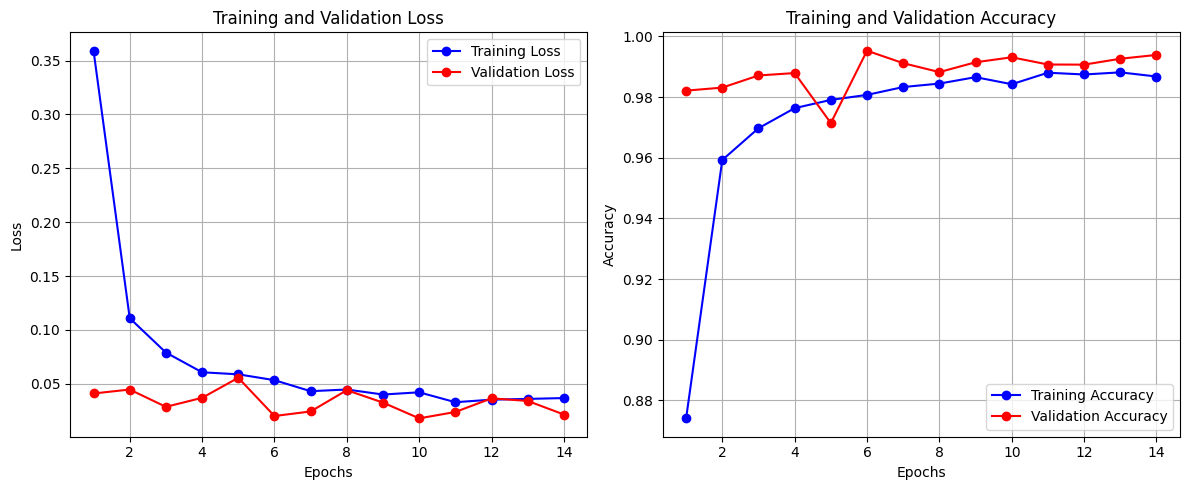


Evaluating best model on validation set...


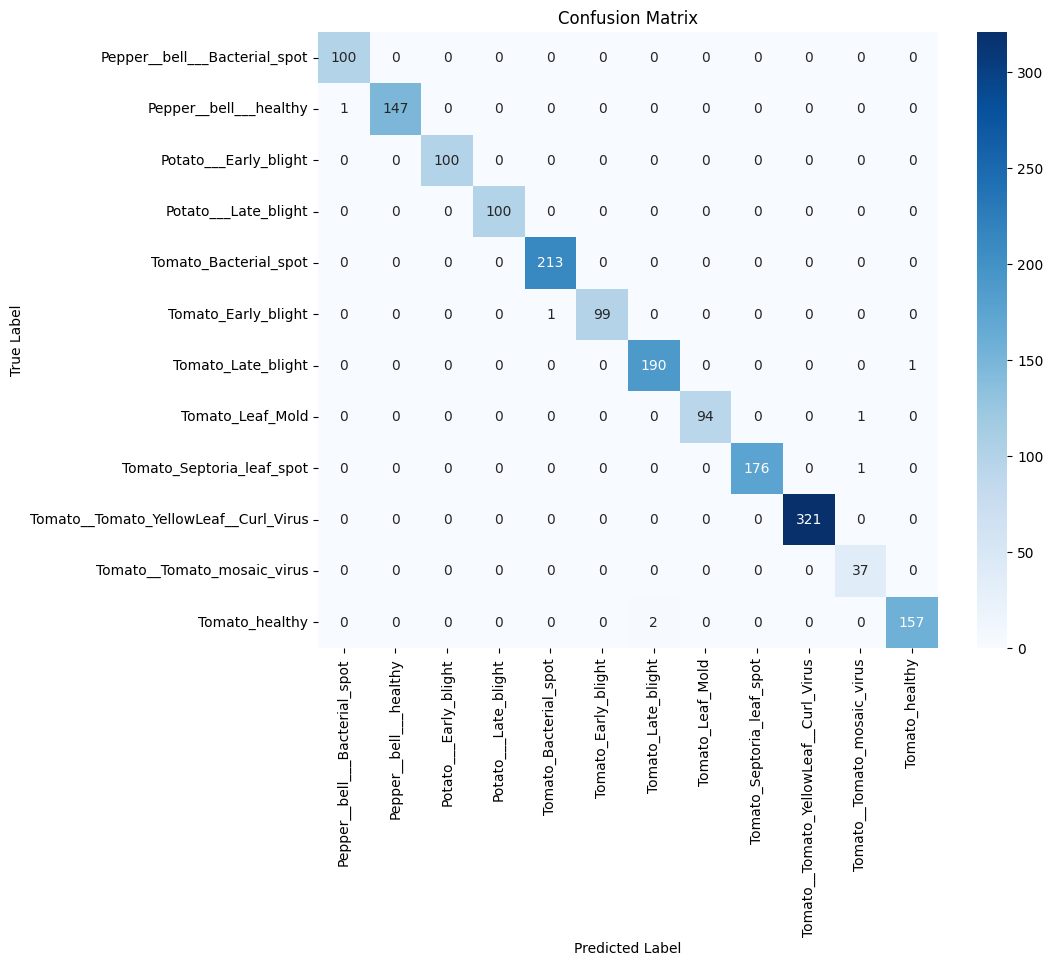

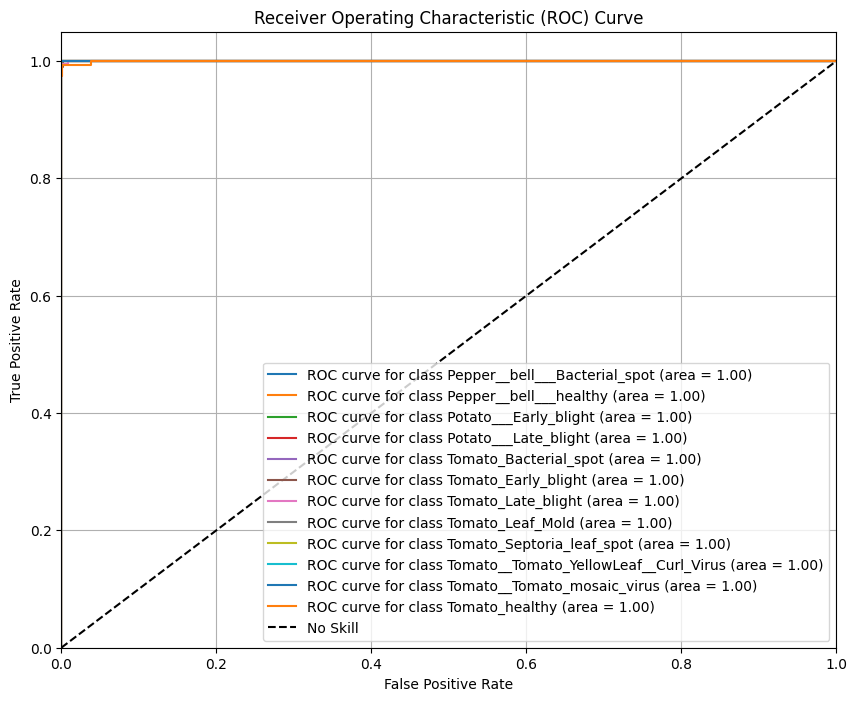

In [188]:
train_model(
    model_stage1,
    train_plantvillage_loader,
    val_plantvillage_loader,
    criterion, optimizer,
    scheduler,
    early_stop,
    epochs=CFG["epochs_stage1"],
    dataset_name="plantvillage",
    class_names=list(plantvillage_label2id.keys()),
    num_classes=plantvillage_num_classes)

In [201]:
cassava_df, cassava_classes = build_cassava_dataframe(CASSAVA_PATH)
train_df, val_df = train_test_split(cassava_df, test_size=0.2, stratify=cassava_df["label"])

train_ds = CassavaDataset(train_df, make_transforms())
val_ds = CassavaDataset(val_df, make_transforms())

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False)

Classes found: ['Cassava___bacterial_blight', 'Cassava___healthy', 'Cassava___mosaic_disease']
Dataset created with 16822 images.


In [202]:
model_stage2, criterion, optimizer, scheduler = setup_model(len(cassava_classes))

In [203]:
early_stop = EarlyStopping(patience=3, save_path="./datasets/checkpoints/efficientnetB0_severity_cassava.pth")


🌿 Epoch 1/20


Validating: 100%|████████████████████████████████████████████████████████████████████| 106/106 [00:42<00:00,  2.47it/s]


Train Loss:0.5226 | Train Acc:0.635 | Train F1:0.638 | Train Prec:0.641 | Train Rec:0.635 | Val Loss:0.2906 | Val Acc:0.749 | Val F1:0.751 | Val Prec:0.753 | Val Rec:0.749
✅ Validation loss improved → 0.2906

🌿 Epoch 2/20


Validating: 100%|████████████████████████████████████████████████████████████████████| 106/106 [00:40<00:00,  2.61it/s]


Train Loss:0.2983 | Train Acc:0.719 | Train F1:0.735 | Train Prec:0.756 | Train Rec:0.719 | Val Loss:0.2511 | Val Acc:0.775 | Val F1:0.778 | Val Prec:0.782 | Val Rec:0.775
✅ Validation loss improved → 0.2511

🌿 Epoch 3/20


Validating: 100%|████████████████████████████████████████████████████████████████████| 106/106 [00:40<00:00,  2.60it/s]


Train Loss:0.2568 | Train Acc:0.750 | Train F1:0.764 | Train Prec:0.781 | Train Rec:0.750 | Val Loss:0.2401 | Val Acc:0.800 | Val F1:0.793 | Val Prec:0.785 | Val Rec:0.800
✅ Validation loss improved → 0.2401

🌿 Epoch 4/20


Validating: 100%|████████████████████████████████████████████████████████████████████| 106/106 [00:42<00:00,  2.50it/s]


Train Loss:0.2605 | Train Acc:0.757 | Train F1:0.771 | Train Prec:0.788 | Train Rec:0.757 | Val Loss:0.2424 | Val Acc:0.791 | Val F1:0.786 | Val Prec:0.790 | Val Rec:0.791
⚠️ No improvement for 1/3 epochs.

🌿 Epoch 5/20


Validating: 100%|████████████████████████████████████████████████████████████████████| 106/106 [00:42<00:00,  2.52it/s]


Train Loss:0.2243 | Train Acc:0.781 | Train F1:0.795 | Train Prec:0.811 | Train Rec:0.781 | Val Loss:0.2420 | Val Acc:0.803 | Val F1:0.798 | Val Prec:0.795 | Val Rec:0.803
⚠️ No improvement for 2/3 epochs.

🌿 Epoch 6/20


Validating: 100%|████████████████████████████████████████████████████████████████████| 106/106 [00:42<00:00,  2.48it/s]


Train Loss:0.2950 | Train Acc:0.747 | Train F1:0.761 | Train Prec:0.778 | Train Rec:0.747 | Val Loss:0.3019 | Val Acc:0.784 | Val F1:0.781 | Val Prec:0.785 | Val Rec:0.784
⚠️ No improvement for 3/3 epochs.
⏹️ Early stopping triggered!


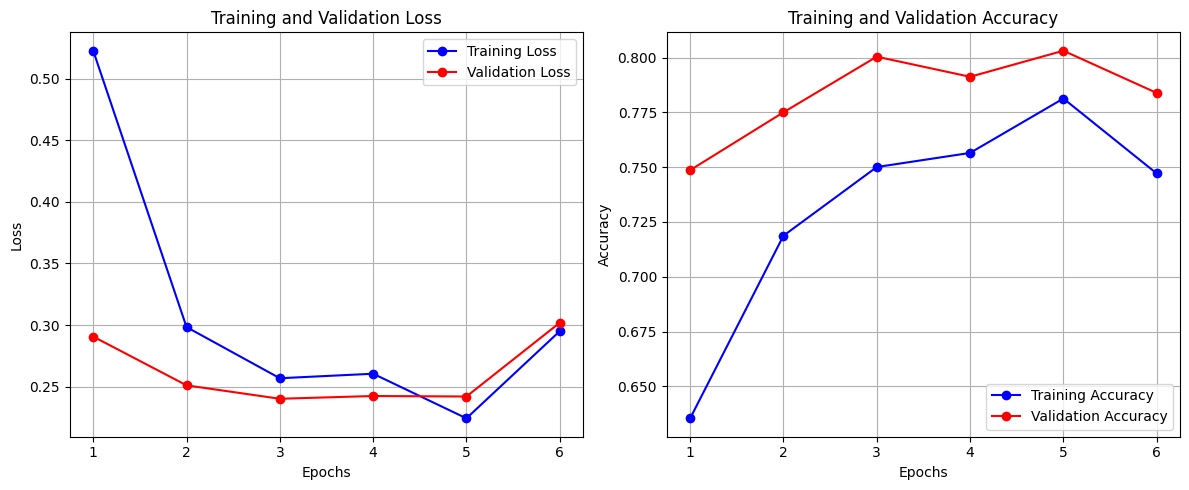


Evaluating best model on validation set...


Validating: 100%|████████████████████████████████████████████████████████████████████| 106/106 [00:41<00:00,  2.54it/s]


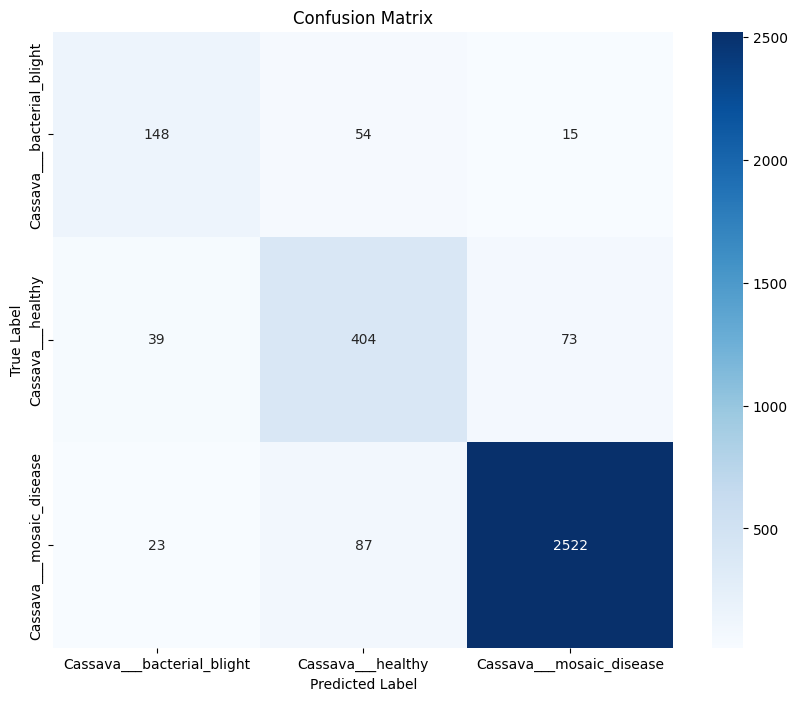

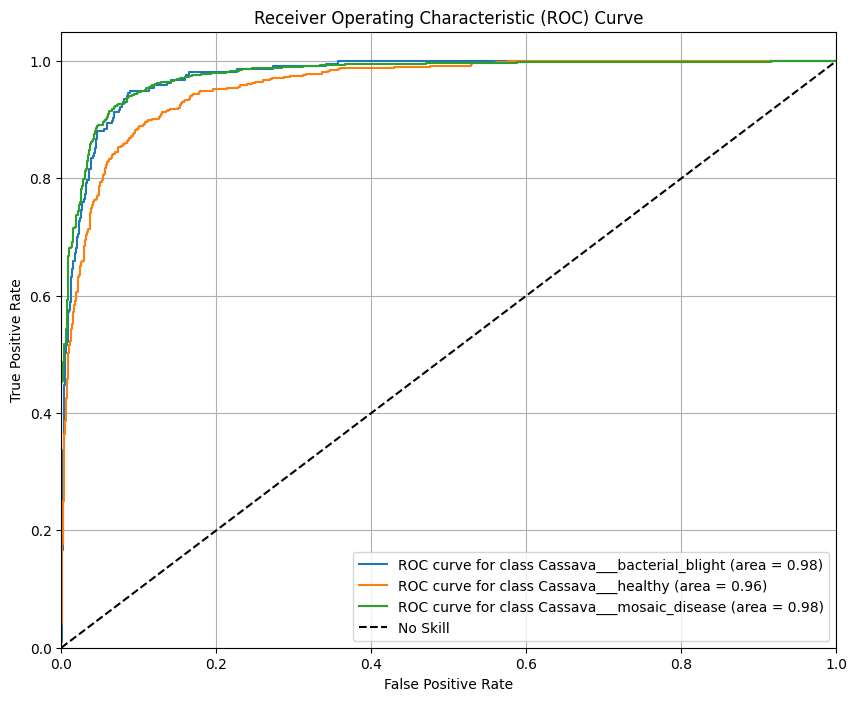

In [204]:
train_model(model_stage2,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            scheduler,
            early_stop,
            epochs=CFG["epochs_stage2"],
            dataset_name="cassava",
            class_names=cassava_classes,
            num_classes=len(cassava_classes))

In [207]:
splits_dir = "./datasets/splits"
os.makedirs(splits_dir, exist_ok=True)

# Save PlantVillage split indices
with open(os.path.join(splits_dir, "train_plantvillage_indices.pkl"), "wb") as f:
    pickle.dump(train_plantvillage_df.index.tolist(), f)
with open(os.path.join(splits_dir, "val_plantvillage_indices.pkl"), "wb") as f:
    pickle.dump(val_plantvillage_df.index.tolist(), f)

# Save Cassava split indices
with open(os.path.join(splits_dir, "train_cassava_indices.pkl"), "wb") as f:
    pickle.dump(train_df.index.tolist(), f)
with open(os.path.join(splits_dir, "val_cassava_indices.pkl"), "wb") as f:
    pickle.dump(val_df.index.tolist(), f)

print(f"✅ Dataset split indices saved to {splits_dir} in .pkl format")

✅ Dataset split indices saved to ./datasets/splits in .pkl format
